# Laboratório 7: Modelo de Epidemia 

### Referente ao capítulo 13

Nesse capítulo, desenvolveremos para um modelo simples: a vacinação para uma epidemia de uma infecção micro-parasítica. Imunidade permanente pode ser atingida através da vacina ou de recuperação natural. Todos nascem suscetíveis à doença. Queremos minimizar o número de infectados e o custo da vacina em um período de tempo fixo. Para isso, estudaremos o modelo compartimental SEIR padrão, onde $S$ é o compatimento de suscetíveis, $E$ é o compartimento de indivíduos infectados, mas não infectantes (período de latência da doença), $I$ é o compartimento dos infectantes e $R$ é o compartimento dos recuperados. A população total é dada por $N(t) = S(t) + E(t) + I(t) + R(t)$. 

Seja $u(t)$ o percentual de suscetíveis sendo vacinados no tempo $t$. 

|Parâmetro|Significado|
|---------|-----------|
|$b$|taxa de nascimento|
|$d$|taxa de morte natural|
|$c$|taxa de transmissão da doença|
|$e^{-1}$|tempo de latência médio da doença|
|$g^{-1}$|período médio de recuperação|
|$a$|taxa de mortalidade da doença|

O problema pode ser descrito por 

$$
\min_u \int_0^T AI(t) + u(t)^2 dt
$$
\begin{align}
\text{sujeito a  }&S'(t) = bN(t) - dS(t) - cS(t)I(t) - u(t)S(t), S(0) = S_0 \ge 0 \\
&E'(t) = cS(t)I(t) - (e + d)E(t), E(0) = E_0 \ge 0 \\
&I'(t) = eE(t) - (g + a + d)I(t), I(0) = I_0 \ge 0 \\
&R'(t) = gI(t) - dR(t) + u(t)S(t), R(0) = R_0 \ge 0 \\ 
&N'(t) = (b - d)N(t) - aI(t), N(0) = N_0 \\ 
&0 \le u(t) \le 0.9
\end{align}

<img src="../images/flow-chat-seir.png" alt="seir" width="500"/>

## Condições Necessárias 

O Hamiltoniano de sistemas desse tipo são muito grandes e, portanto, não precisam ser descrito, dado que a intuição seja clara. Vamos usar as variáveis $S, E, I, N$ e $R = N - S - E - I$. Se usássemos a variável $R$, a função adjunta seria negativa. 

### Equação adjunta 

Sejam $\lambda_1(t),\lambda_2(t),\lambda_3(t) \text{ e } \lambda_4(t)$ funções deriváveis por partes. Assim 
   
$\lambda_1'(t) = - \frac{\partial H}{\partial S} = - \lambda_1(- d - cI - u) - \lambda_2(cI)$

$\lambda_2'(t) = - \frac{\partial H}{\partial E} = \lambda_2(e + d) - \lambda_3(e)$

$\lambda_3'(t) = - \frac{\partial H}{\partial I} = -A - \lambda_1(- cS) - \lambda_2(cS) + \lambda_3(g + a + d) + \lambda_4(a)$

$\lambda_4'(t) = - \frac{\partial H}{\partial N} = -\lambda_1(b) - \lambda_4(b - d)$

### Condição de transversalidade 

$
\lambda_1(T) = \lambda_2(T) = \lambda_3(T) = \lambda_4(T) = 0
$

### Condição de otimalidade

$$
\frac{\partial H}{\partial u} = 2u - \lambda_1(S) 
$$

$\frac{\partial H}{\partial u} > 0 \Rightarrow u^*(t) = 0 \Rightarrow 2u - \lambda_1(S) > 0 \Rightarrow S\lambda_1 < 0 \Rightarrow \frac{1}{2}S\lambda_1 < 0 $

$\frac{\partial H}{\partial u} < 0 \Rightarrow u^*(t) = 0.9 \Rightarrow 2u - \lambda_1(S) < 0 \Rightarrow 1.8 < S\lambda_1 \Rightarrow \frac{1}{2}S\lambda_1 > 0.9$

$\frac{\partial H}{\partial u} = 0 \Rightarrow 0 \leq u^*(t) \leq 0.9 \Rightarrow 2u - \lambda_1(S) = 0 \Rightarrow u^*(t) = \frac{1}{2}S\lambda_1 \Rightarrow 0 \leq \frac{1}{2}S\lambda_1 \leq 0.9$

Portanto $u^*(t) = \max\left\{0, \min\left\{\frac{1}{2}S\lambda_1,0.9\right\}\right\}$

### Importanto as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

Aqui podemos descrever as funções necessárias para a classe. Estamos lidando com variáveis multidimensionais no tempo. Portanto, vamos utilizar `numpy.array` como forma de escrita. Nessa escrita, cada coluna $i$ é um vetor correspondente ao estado $i$. Nesse caso teremos $S \to 0, E \to 1, I \to 2, N \to 3$. 

In [2]:
parameters = {'a': None, 'b': None, 'c': None, 'd': None, 'e': None, 'g': None, 'A': None}

diff_state = lambda t, x, u, par: np.array([
    par['b']*x[3] - (par['d'] + par['c']*x[2] + u[0])*x[0], 
    par['c']*x[0]*x[2] - (par['e'] + par['d'])*x[1],
    par['e']*x[1] - (par['g'] + par['a'] + par['d'])*x[2],
    (par['b'] - par['d'])*x[3] - par['a']*x[2]
])

diff_lambda = lambda t, x, u, lambda_, par: np.array([
    lambda_[0]*(par['d'] + par['c']*x[2] + u[0]) - lambda_[1]*(par['c']*x[2]),
    lambda_[1]*(par['e'] + par['d']) - lambda_[2]*par['e'], 
    -par['A'] + lambda_[0]*par['c']*x[0] - lambda_[1]*par['c']*x[0] + \
               lambda_[2]*(par['g'] + par['a'] + par['d']) + lambda_[3]*par['a'], 
    -lambda_[0]*par['b'] - lambda_[3]*(par['b'] - par['d']) 
])

update_u = lambda t, x, lambda_, par: np.minimum(0.9, np.maximum(0.5*x[0]*lambda_[0], 0.0))

## Aplicando a classe ao exemplo 

Vamos fazer algumas exeperimentações. Sinta-se livre para variar os parâmetros. Nesse caso passaremos os limites como parâmetros do método `solve`. Precisamos nos atentar a alguns parâmetros novos da classe: 

- `n_controls`: ele indica o número de controles do problema. Ele é por padrão 1. 
- `n_states`: ele indica o número de estados do problema. Ele é por padrão 1. 
- `diff_phi`: já é conhecido. Observe a estrutura dele: um array com uma linha e 4 colunas, um para cada estado. 

In [3]:
problem = OptimalControl(diff_state, diff_lambda, update_u, 
                         n_controls = 1, n_states = 4, 
                         diff_phi = lambda x, par: np.zeros(shape = (1, 4)), 
                         bounds = [(0,0.9)])

In [4]:
x0 = np.array([1000, 100, 50, 1165]) # S0, E0, I0, N0 
T = 20
parameters['A'] = 0.1
parameters['a'] = 0.2
parameters['b'] = 0.525
parameters['c'] = 0.0001
parameters['d'] = 0.5
parameters['e'] = 0.5
parameters['g'] = 0.1

Importante lembrar que esses gráficos são padrões e podem ser melhorados manualmente. 

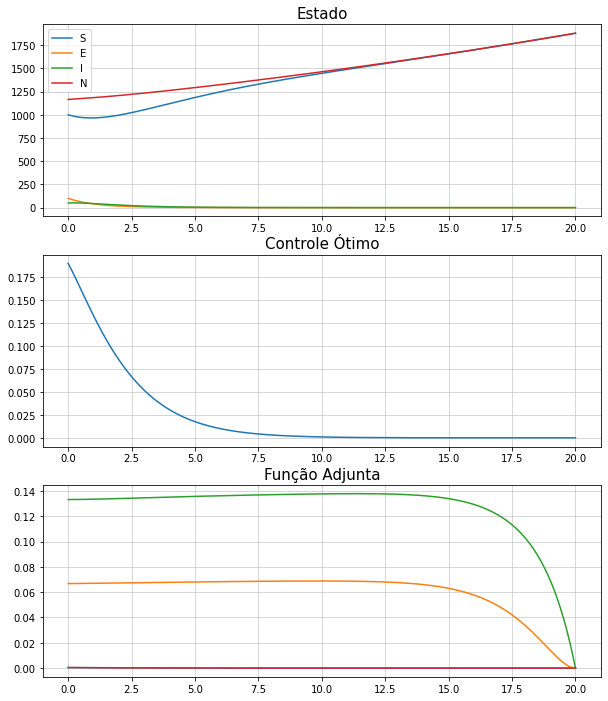

In [5]:
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)
ax[0].legend(['S','E','I','N'])
plt.show()

Observamos que $c$ é pequeno, o que causa uma baixa incidência da doença. A vacinação começa mais alta no início da epidemia, o que impede o crescimento da doença. Esse combo faz o gráfico dos infectados morrer logo. A vacinação termina com pouco mais de 7.5 anos. Os recuperados também tendem a 0, pois as mortes naturais acabam por se tornar mais altas do que as recuperações dos infectados e vacinações. Façamos $c = 0.01$, uma taxa relativamente mais alta, que torna o número de infectados presente além do tempo considerado e também mantém a vacinação no máximo quase até o final. 

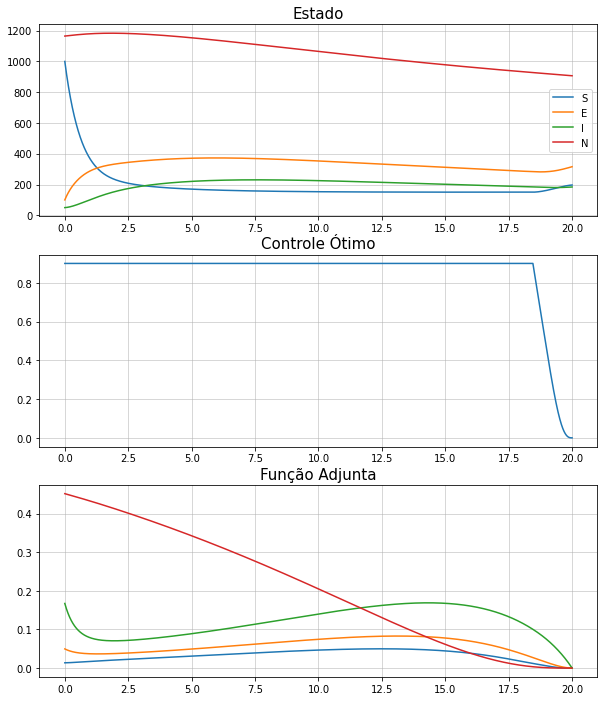

In [6]:
parameters['c'] = 0.01
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)
ax[0].legend(['S','E','I','N'])
plt.show()

## Experimentação 

Existem várias variações que podem ser feitas, portanto sugerimos que experimente esse modelo com variações em cada parâmetro. 

In [7]:
#t,x,u,lambda_ = problem.solve(x0, T, parameters)
#ax = problem.plotting(t,x,u,lambda_)
#ax[0].legend(['S','E','I','R'])
#plt.show()